In [1]:
from scripts.main import get_loss
from utils.slam_helpers import transform_to_frame,transformed_params2rendervar,transformed_params2depthplussilhouette
from diff_gaussian_rasterization import GaussianRasterizer as Renderer
import torch
from utils.slam_helpers import l1_loss_v1
from utils.recon_helpers import energy_mask, setup_camera
from utils.slam_external import calc_ssim
import numpy as np
import torch

System Paths:
/media/thesis_ssd/code/EndoGSLAM/EndoGSLAM
/media/thesis_ssd/anaconda/envs/endogslam/lib/python310.zip
/media/thesis_ssd/anaconda/envs/endogslam/lib/python3.10
/media/thesis_ssd/anaconda/envs/endogslam/lib/python3.10/lib-dynload

/media/thesis_ssd/anaconda/envs/endogslam/lib/python3.10/site-packages


In [2]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def get_depth_and_silhouette(pts_3D, w2c):
    """
    Function to compute depth and silhouette for each gaussian.
    These are evaluated at gaussian center.
    """
    # Depth of each gaussian center in camera frame
    pts4 = torch.cat((pts_3D, torch.ones_like(pts_3D[:, :1])), dim=-1)
    pts_in_cam = (w2c @ pts4.transpose(0, 1)).transpose(0, 1)
    depth_z = pts_in_cam[:, 2].unsqueeze(-1) # [num_gaussians, 1]
    depth_z_sq = torch.square(depth_z) # [num_gaussians, 1]

    # Depth and Silhouette
    depth_silhouette = torch.zeros((pts_3D.shape[0], 3)).cuda().float()
    depth_silhouette[:, 0] = depth_z.squeeze(-1)
    depth_silhouette[:, 1] = 1.0
    depth_silhouette[:, 2] = depth_z_sq.squeeze(-1)
    
    return depth_silhouette

# def transformed_GRNparams2rendervar(params, transformed_pts):
#     rendervar = {
#         'means3D': transformed_pts,
#         'rotations': params['unnorm_rotations'],
#         'opacities': params['logit_opacities'],
#         # 'scales': torch.exp(torch.tile(params['log_scales'], (1, 3))),
#         'means2D': torch.zeros_like(params['means3D'], requires_grad=True, device="cuda") + 0,
#         'colors_precomp' : params['rgb_colors'],
#         'scales' : params['log_scales']
#     }
    return rendervar

def transformed_GRNparams2rendervar(params, transformed_pts):
    rendervar = {
        'means3D': transformed_pts,
        'rotations': F.normalize(params['unnorm_rotations']),
        'opacities': torch.sigmoid(params['logit_opacities']),
        # 'scales': torch.exp(torch.tile(params['log_scales'], (1, 3))),
        'means2D': torch.zeros_like(params['means3D'], requires_grad=True, device="cuda") + 0
    }
    if params['log_scales'].shape[1] == 1:
        rendervar['colors_precomp'] = params['rgb_colors']
        rendervar['scales'] = torch.tile(params['log_scales'], (1, 3))
        # print('using uniform scales')
    else:
        try: 
            rendervar['shs'] = torch.cat((params['rgb_colors'].reshape(params['rgb_colors'].shape[0], 3, -1).transpose(1, 2), params['feature_rest'].reshape(params['rgb_colors'].shape[0], 3, -1).transpose(1, 2)), dim=1)
            rendervar['scales'] = params['log_scales']
        except: 
            rendervar['colors_precomp'] = params['rgb_colors']
            rendervar['scales'] = params['log_scales']
    return rendervar

# def transformed_GRNparams2depthplussilhouette(params, w2c, transformed_pts):
#     rendervar = {
#         'means3D': transformed_pts,
#         'colors_precomp': get_depth_and_silhouette(transformed_pts, w2c),
#         'rotations': params['unnorm_rotations'],
#         'opacities': params['logit_opacities'],
#         # 'scales': torch.exp(torch.tile(params['log_scales'], (1, 3))),
#         'means2D': torch.zeros_like(params['means3D'], requires_grad=True, device="cuda") + 0
#     }
#     if params['log_scales'].shape[1] == 1:
#         rendervar['scales'] = torch.tile(params['log_scales'], (1, 3))
#     else:
#         rendervar['scales'] = params['log_scales']
#     return rendervar

def transformed_GRNparams2depthplussilhouette(params, w2c, transformed_pts):
    rendervar = {
        'means3D': transformed_pts,
        'colors_precomp': get_depth_and_silhouette(transformed_pts, w2c),
        'rotations': F.normalize(params['unnorm_rotations']),
        'opacities': torch.sigmoid(params['logit_opacities']),
        # 'scales': torch.exp(torch.tile(params['log_scales'], (1, 3))),
        'means2D': torch.zeros_like(params['means3D'], requires_grad=True, device="cuda") + 0
    }
    if params['log_scales'].shape[1] == 1:
        rendervar['scales'] = torch.tile(params['log_scales'], (1, 3))
    else:
        rendervar['scales'] = params['log_scales']
    return rendervar


def get_loss(params, curr_data, variables, iter_time_idx, loss_weights, use_sil_for_loss, 
             sil_thres, use_l1,ignore_outlier_depth_loss, tracking=False, 
             mapping=False, do_ba=False, plot_dir=None, visualize_tracking_loss=False, tracking_iteration=None,GRN_input = False,plotting = False):
    global w2cs, w2ci
    # Initialize Loss Dictionary
    losses = {}

    if tracking:
        # Get current frame Gaussians, where only the camera pose gets gradient
        transformed_pts = transform_to_frame(params, iter_time_idx, 
                                             gaussians_grad=False,
                                             camera_grad=True)

    elif mapping:
        if do_ba: # Bundle Adjustment
            # Get current frame Gaussians, where both camera pose and Gaussians get gradient
            transformed_pts = transform_to_frame(params, iter_time_idx,
                                                 gaussians_grad=True,
                                                 camera_grad=True)
        else:
            # Get current frame Gaussians, where only the Gaussians get gradient
            transformed_pts = transform_to_frame(params, iter_time_idx,
                                                 gaussians_grad=True,
                                                 camera_grad=False)
    else:
        # Get current frame Gaussians, where only the Gaussians get gradient
        transformed_pts = transform_to_frame(params, iter_time_idx,
                                             gaussians_grad=True,
                                             camera_grad=False)
    # print(transformed_pts.shape)
    # Initialize Render Variables
    if not GRN_input:
        rendervar = transformed_params2rendervar(params, transformed_pts)
        depth_sil_rendervar = transformed_params2depthplussilhouette(params, curr_data['w2c'],
                                                                    transformed_pts)
    else:
        # raise NotImplementedError('Not implemented yet')
        rendervar = transformed_GRNparams2rendervar(params,transformed_pts)
        depth_sil_rendervar = transformed_GRNparams2depthplussilhouette(params, curr_data['w2c'],
                                                            transformed_pts)
    
    # Visualize the Rendered Images
    # online_render(curr_data, iter_time_idx, rendervar, dev_use_controller=False)
        
    # RGB Rendering
    rendervar['means2D'].retain_grad()
    im, radius, _ = Renderer(raster_settings=curr_data['cam'])(**rendervar)
    variables['means2D'] = rendervar['means2D'] # Gradient only accum from colour render for densification
    if plotting:
        plt.imshow(im.permute(1,2,0).cpu().detach())
        plt.show()
    # Depth & Silhouette Rendering
    depth_sil, _, _ = Renderer(raster_settings=curr_data['cam'])(**depth_sil_rendervar)

    depth = depth_sil[0, :, :].unsqueeze(0)
    if plotting:
        plt.imshow(depth.squeeze(0).cpu().detach())
        plt.colorbar()
        plt.show()
    silhouette = depth_sil[1, :, :]

    presence_sil_mask = (silhouette > sil_thres)
    depth_sq = depth_sil[2, :, :].unsqueeze(0)
    uncertainty = depth_sq - depth**2
    uncertainty = uncertainty.detach()

    # Mask with valid depth values (accounts for outlier depth values)
    nan_mask = (~torch.isnan(depth)) & (~torch.isnan(uncertainty))
    bg_mask = energy_mask(curr_data['im'])
    if ignore_outlier_depth_loss:
        depth_error = torch.abs(curr_data['depth'] - depth) * (curr_data['depth'] > 0)
        mask = (depth_error < 20*depth_error.mean())
        mask = mask & (curr_data['depth'] > 0)
    else:
        mask = (curr_data['depth'] > 0)
    mask = mask & nan_mask & bg_mask
    # Mask with presence silhouette mask (accounts for empty space)
    if tracking and use_sil_for_loss:
        mask = mask & presence_sil_mask
    if plotting:
        plt.imshow(mask.squeeze(0).cpu().detach())
        plt.colorbar()
        plt.show()

    # Depth loss
    if use_l1:
        mask = mask.detach()
        if tracking:
            losses['depth'] = torch.abs(curr_data['depth'] - depth)[mask].sum()
        else:
            losses['depth'] = torch.abs(curr_data['depth'] - depth)[mask].mean()
    # RGB Loss
    if tracking and (use_sil_for_loss or ignore_outlier_depth_loss):
        color_mask = torch.tile(mask, (3, 1, 1))
        color_mask = color_mask.detach()
        losses['im'] = torch.abs(curr_data['im'] - im)[color_mask].sum()
    elif tracking:
        losses['im'] = torch.abs(curr_data['im'] - im).sum()
    else:
        losses['im'] = 0.8 * l1_loss_v1(im, curr_data['im']) + 0.2 * (1.0 - calc_ssim(im, curr_data['im']))
    if plotting:
        plt.imshow(curr_data['im'].permute(1,2,0).cpu().detach())
        plt.show()
        plt.imshow(curr_data['depth'].permute(1,2,0).cpu().detach())
        plt.colorbar()
        plt.show()
    weighted_losses = {k: v * loss_weights[k] for k, v in losses.items()}
    loss = sum(weighted_losses.values())

    seen = radius > 0
    variables['max_2D_radius'][seen] = torch.max(radius[seen], variables['max_2D_radius'][seen])
    variables['seen'] = seen
    weighted_losses['loss'] = loss

    return loss, variables, weighted_losses


In [3]:
def initialize_params(init_pt_cld, num_frames, mean3_sq_dist, use_simplification=True):
    num_pts = init_pt_cld.shape[0]
    means3D = init_pt_cld[:, :3] # [num_gaussians, 3]
    unnorm_rots = np.tile([1, 0, 0, 0], (num_pts, 1)) # [num_gaussians, 3]
    logit_opacities = torch.zeros((num_pts, 1), dtype=torch.float, device="cuda")
    params = {
        'means3D': means3D,
        'rgb_colors': init_pt_cld[:, 3:6],
        'unnorm_rotations': unnorm_rots,
        'logit_opacities': logit_opacities,
        'log_scales': torch.tile(torch.log(torch.sqrt(mean3_sq_dist))[..., None], (1, 1 if use_simplification else 3)),
        # 'log_scales': torch.ones(num_pts,1)*-200,
    }
    if not use_simplification:
        params['feature_rest'] = torch.zeros(num_pts, 45) # set SH degree 3 fixed

    # Initialize a single gaussian trajectory to model the camera poses relative to the first frame
    cam_rots = np.tile([1, 0, 0, 0], (1, 1))
    cam_rots = np.tile(cam_rots[:, :, None], (1, 1, num_frames))
    params['cam_unnorm_rots'] = cam_rots
    params['cam_trans'] = np.zeros((1, 3, num_frames))

    for k, v in params.items():
        # Check if value is already a torch tensor
        if not isinstance(v, torch.Tensor):
            params[k] = torch.nn.Parameter(torch.tensor(v).cuda().float().contiguous().requires_grad_(True))
        else:
            params[k] = torch.nn.Parameter(v.cuda().float().contiguous().requires_grad_(True))

    variables = {'max_2D_radius': torch.zeros(params['means3D'].shape[0]).cuda().float(),
                 'means2D_gradient_accum': torch.zeros(params['means3D'].shape[0]).cuda().float(),
                 'denom': torch.zeros(params['means3D'].shape[0]).cuda().float(),
                 'timestep': torch.zeros(params['means3D'].shape[0]).cuda().float()}

    return params, variables


def get_pointcloud(color, depth, intrinsics, w2c, transform_pts=True, 
                   mask=None, compute_mean_sq_dist=False, mean_sq_dist_method="projective"):
    width, height = color.shape[2], color.shape[1]
    CX = intrinsics[0][2]
    CY = intrinsics[1][2]
    FX = intrinsics[0][0]
    FY = intrinsics[1][1]

    # Compute indices of pixels
    x_grid, y_grid = torch.meshgrid(torch.arange(width).cuda().float(),
                                    torch.arange(height).cuda().float(),
                                    indexing='xy')
    xx = (x_grid - CX)/FX
    yy = (y_grid - CY)/FY
    xx = xx.reshape(-1)
    yy = yy.reshape(-1)
    depth_z = depth[0].reshape(-1)

    # Initialize point cloud
    pts_cam = torch.stack((xx * depth_z, yy * depth_z, depth_z), dim=-1)
    if transform_pts:
        pix_ones = torch.ones(height * width, 1).cuda().float()
        pts4 = torch.cat((pts_cam, pix_ones), dim=1)
        c2w = torch.inverse(w2c)
        pts = (c2w @ pts4.T).T[:, :3]
    else:
        pts = pts_cam

    # Compute mean squared distance for initializing the scale of the Gaussians
    if compute_mean_sq_dist:
        if mean_sq_dist_method == "projective":
            # Projective Geometry (this is fast, farther -> larger radius)
            scale_gaussian = depth_z / ((FX + FY)/2)
            mean3_sq_dist = scale_gaussian**2
        else:
            raise ValueError(f"Unknown mean_sq_dist_method {mean_sq_dist_method}")
    
    # Colorize point cloud
    cols = torch.permute(color, (1, 2, 0)).reshape(-1, 3) # (C, H, W) -> (H, W, C) -> (H * W, C)
    point_cld = torch.cat((pts, cols), -1)
    # Image.fromarray(np.uint8((torch.permute(color, (1, 2, 0)) * mask.reshape(320, 320, 1)).detach().cpu().numpy()*255), 'RGB').save('gaussian.png')

    # Select points based on mask
    if mask is not None:
        point_cld = point_cld[mask]
        if compute_mean_sq_dist:
            mean3_sq_dist = mean3_sq_dist[mask]

    if compute_mean_sq_dist:
        return point_cld, mean3_sq_dist
    else:
        return point_cld

In [4]:
intrinsics =  torch.tensor([[300., 0., 16.], [0., 300., 16.], [0., 0., 1.]]).cuda()
w2c = torch.eye(4).cuda()
cam = setup_camera(336, 336, intrinsics.cpu().numpy(), w2c.detach().cpu().numpy(), use_simplification=False)
cam

GaussianRasterizationSettings(image_height=336, image_width=336, tanfovx=0.56, tanfovy=0.56, bg=tensor([0., 0., 0.], device='cuda:0'), scale_modifier=1.0, viewmatrix=tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]], device='cuda:0'), projmatrix=tensor([[[ 1.7857,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  1.7857,  0.0000,  0.0000],
         [-0.9048, -0.9048,  1.0001,  1.0000],
         [ 0.0000,  0.0000, -0.0100,  0.0000]]], device='cuda:0'), sh_degree=3, campos=tensor([0., 0., 0.], device='cuda:0'), prefiltered=False)

In [5]:
# color = torch.randn(3,336,336).cuda()
# depth = torch.randn(1,336,336).cuda()
import cv2
color = cv2.imread('/media/thesis_ssd/code/EndoGSLAM/EndoGSLAM/data/endonerf_cutting/images/frame-000000.color.png')
depth = cv2.imread('/media/thesis_ssd/code/EndoGSLAM/EndoGSLAM/data/endonerf_cutting/depth/frame-000000.png')
color = cv2.resize(color, (336,336))
depth = cv2.resize(depth, (336,336))
color = cv2.cvtColor(color,cv2.COLOR_BGR2RGB)
color = torch.Tensor(color).permute(2,0,1).cuda()
color = (color-color.min())/(color.max()-color.min())

depth = torch.Tensor(depth)[:,:,0].unsqueeze(0).cuda()*3+1


pt_cloud,mean3_sq_dist= get_pointcloud(color,depth,intrinsics,w2c,compute_mean_sq_dist=True)
params,variables = initialize_params(pt_cloud,1,mean3_sq_dist)
# Initialize Mapping Data for selected frame
curr_data = {'cam': cam, 'im': color, 'depth': depth, 'id': 0, 'intrinsics': intrinsics, 
                'w2c': w2c, 'iter_gt_w2c_list': w2c}
loss_weights=dict(
    im=0.5,
    depth=1.0,
)

In [6]:
loss, variables, losses = get_loss(params, curr_data, variables, 0, loss_weights,
                                    True, 0.5,
                                    True,True, tracking=True, 
                                    plot_dir=None, visualize_tracking_loss=False,
                                    tracking_iteration=0)

using uniform scales


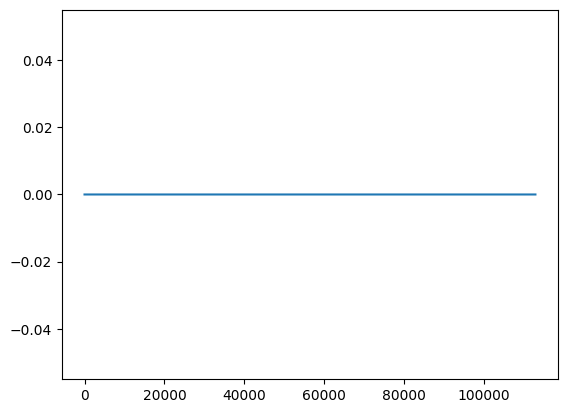

In [7]:
plt.plot(params['logit_opacities'].cpu().detach())

In [8]:
params['logit_opacities']

Parameter containing:
tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], device='cuda:0', requires_grad=True)

## U-Net GRN

In [9]:
import torch
import torch.nn as nn


class GaussianRegressionNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.e1 = EncoderBlock(4,32)    # 336x336x4 --> 168x168x32
        self.e2 = EncoderBlock(32,64)   # 168x168x32 --> 84x84x64
        self.e3 = EncoderBlock(64,128)  # 84x84x64 --> 42x42x128
        self.e4 = EncoderBlock(128,256) #  42x42x128 --> 21x21x256


        self.b = Conv_Block(256,512)    # 21x21x256 --> 21x21x512

        self.d1 = DecoderBlock(512,256) # 21x21x512 --> 42x42x256
        self.d2 = DecoderBlock(256,128) # 42x42x256 --> 84x84x128
        self.d3 = DecoderBlock(128,64)  # 84x84x128 --> 168x168x64
        self.d4 = DecoderBlock(64,32)   # 168x168x64 --> 336x336x32

        self.classifier = nn.Conv2d(32,8,kernel_size=1,padding = 0) 
        self.output = nn.Sigmoid()

    def forward(self,inputs):

        s1,p1 = self.e1(inputs)     # 336x336x4 --> 168x168x32
        s2,p2 = self.e2(p1)         # 168x168x32 --> 84x84x64
        s3,p3 = self.e3(p2)         # 84x84x64 --> 42x42x128
        s4,p4 = self.e4(p3)         #  42x42x128 --> 21x21x256

        b = self.b(p4)              # 21x21x256 --> 21x21x512
        
        d1 = self.d1(b,s4)          # 21x21x512 --> 42x42x256
        d2 = self.d2(d1,s3)         # 42x42x256 --> 84x84x128
        d3 = self.d3(d2,s2)         # 84x84x128 --> 168x168x64
        d4 = self.d4(d3,s1)         # 168x168x64 --> 336x336x32
        cls = self.classifier(d4)   # 336x336x32 --> 336x336x8
        return cls


class Conv_Block(nn.Module):
    def __init__(self,ch_in,ch_out,kernel_size=3,padding = 1):
        super().__init__()
        self.conv_1 = nn.Conv2d(ch_in,ch_out, kernel_size = kernel_size, padding = padding)
        self.conv_2 = nn.Conv2d(ch_out,ch_out,kernel_size = kernel_size, padding = padding)


        self.batchnorm1 = nn.BatchNorm2d(ch_out)
        self.batchnorm2 = nn.BatchNorm2d(ch_out)

        self.relu = nn.ReLU()

    def forward(self,inputs):
        x = self.conv_1(inputs)
        x = self.batchnorm1(x)
        x = self.relu(x)

        x = self.conv_2(x)
        x = self.batchnorm2(x)
        return self.relu(x)



class EncoderBlock(nn.Module):
    def __init__(self,ch_in,ch_out):
        super().__init__()
        self.conv = Conv_Block(ch_in,ch_out)
        self.pool = nn.MaxPool2d((2,2))


    def forward(self,inputs):
        x = self.conv(inputs)
        p = self.pool(x)


        return x,p
    

class DecoderBlock(nn.Module):
    def __init__(self,ch_in,ch_out):
        super().__init__()
        self.up = nn.ConvTranspose2d(ch_in,ch_out,kernel_size=2,stride = 2,padding = 0) # Strided transpose conv with no padding doubles size
        self.conv = Conv_Block(2*ch_out,ch_out) # We concatenate the skip connection, so we get 2x ch_out channels

    def forward(self,inputs,skip):
        x = self.up(inputs)
        x = torch.cat([x,skip],axis = 1)
        return self.conv(x)    
    

model = GaussianRegressionNetwork()

In [10]:
input = torch.randn(1,4,336,336)
output = model(input)

In [11]:
F.normalize(output,dim = [1,2])

tensor([[[[ 1.8018e-02,  2.4875e-02,  3.9912e-02,  ...,  1.6502e-02,
            1.5516e-02,  3.3737e-02],
          [ 1.2421e-02,  6.4220e-03,  2.7330e-02,  ...,  1.0370e-02,
           -5.7171e-05,  2.8815e-02],
          [ 4.2423e-02,  3.9017e-02,  2.7555e-02,  ...,  2.4846e-02,
            5.1048e-02,  2.3428e-02],
          ...,
          [ 9.7313e-04,  1.2757e-02,  1.6469e-02,  ...,  3.9872e-02,
            2.5533e-02,  4.7141e-02],
          [ 2.6085e-02,  4.0004e-02,  4.3536e-02,  ...,  3.1927e-02,
            1.9194e-02,  4.6977e-02],
          [ 3.0125e-02,  2.9389e-02,  2.0493e-02,  ...,  1.7361e-02,
            3.0815e-02,  5.6601e-02]],

         [[-4.7370e-03,  5.0960e-03,  5.7022e-03,  ..., -1.1853e-02,
           -9.8145e-03, -1.1236e-02],
          [ 1.3926e-02, -2.2511e-03, -5.0408e-03,  ..., -5.3756e-03,
           -5.5533e-03, -2.1463e-03],
          [-5.5118e-03, -1.2561e-02,  8.0925e-03,  ..., -5.5962e-05,
            1.1161e-02, -1.4764e-02],
          ...,
     

In [12]:
cols = torch.permute(output[0], (1, 2, 0)).reshape(-1, 8) # (C, H, W) -> (H, W, C) -> (H * W, C)
rots_norm = (cols[:,:4]-cols[:,:4].min())/(cols[:,:4].max()-cols[:,:4].min())
params['unnorm_rotations'] = rots_norm.cuda()
scales_norm = (cols[:,4:7]-cols[:,4:7].min())/(cols[:,4:7].max()-cols[:,4:7].min())
params['log_scales'] = rots_norm[:,None].cuda()
opacities_norm = (cols[:,7]-cols[:,7].min())/(cols[:,7].max()-cols[:,7].min())
params['logit_opacities'] = opacities_norm.cuda()

In [13]:
loss, variables, losses = get_loss(params, curr_data, variables, 0, loss_weights,
                                    True, 0.5,
                                    True,True, tracking=True, 
                                    plot_dir=None, visualize_tracking_loss=False,
                                    tracking_iteration=0,GRN_input=False,plotting = False)

using uniform scales


In [14]:
output[:,:,0,0]

tensor([[ 0.2696, -0.0709, -0.5459,  0.0146,  0.1353, -0.1903,  0.4024, -0.2844]],
       grad_fn=<SelectBackward0>)

tensor(150.8175, device='cuda:0', grad_fn=<AddBackward0>)


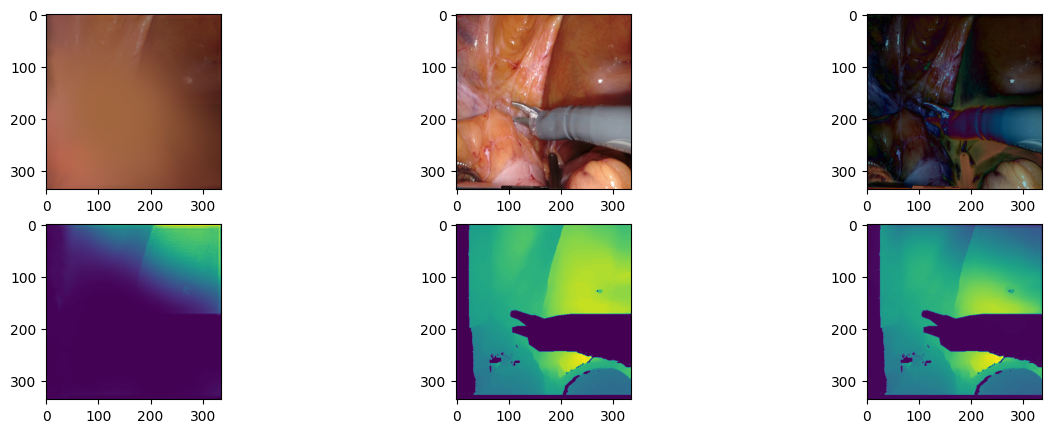

In [15]:
import cv2
color = cv2.imread('/media/thesis_ssd/code/EndoGSLAM/EndoGSLAM/data/endonerf_cutting/images/frame-000000.color.png')
depth = cv2.imread('/media/thesis_ssd/code/EndoGSLAM/EndoGSLAM/data/endonerf_cutting/depth/frame-000000.png')
color = cv2.resize(color, (336,336))
depth = cv2.resize(depth, (336,336))
color = cv2.cvtColor(color,cv2.COLOR_BGR2RGB)
color = torch.Tensor(color).permute(2,0,1).cuda()
color = (color-color.min())/(color.max()-color.min())

depth = torch.Tensor(depth)[:,:,0].unsqueeze(0).cuda()*3+1

model = GaussianRegressionNetwork()
mask = depth>1
mask = mask.unsqueeze(0).tile(1,3,1,1)
mask = mask[0,0,:,:].reshape(-1)
pt_cloud,mean3_sq_dist= get_pointcloud(color,depth,intrinsics,w2c,compute_mean_sq_dist=True,mask = mask)
params,variables = initialize_params(pt_cloud,1,mean3_sq_dist)
# Initialize Mapping Data for selected frame
curr_data = {'cam': cam, 'im': color, 'depth': depth, 'id': 0, 'intrinsics': intrinsics, 
                'w2c': w2c, 'iter_gt_w2c_list': w2c}
loss_weights=dict(
    im=0.5,
    depth=1.0,
)


optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001)
input = torch.cat([curr_data['im'],curr_data['depth']],axis = 0).unsqueeze(0).cuda()
model.cuda()
losses_list = []
for iter in range(1):
    optimizer.zero_grad()
    output = model(input)
    # print(output)
    cols = torch.permute(output[0], (1, 2, 0)).reshape(-1, 8) # (C, H, W) -> (H, W, C) -> (H * W, C)
    cols.retain_grad()
    rots = cols[:,:4]

    scales_norm = cols[:,4:7]
    opacities = cols[:,7][:,None]
    # print(scales_norm.shape)
    # scales_norm = torch.log(scales_norm[:,0]).unsqueeze(1)
    # scales_norm.retain_grad()
    params['unnorm_rotations'] = rots[mask]
    params['log_scales'] = scales_norm[mask]
    params['logit_opacities'] = opacities[mask]
    scales_norm.retain_grad()

    # params['log_scales'] = torch.nn.Parameter(scales_norm[:,None].cuda())
    # opacities_norm = (cols[:,7]-cols[:,7].min())/(cols[:,7].max()-cols[:,7].min())
    # params['logit_opacities'] = opacities_norm[:,None]
    # rendervar = {
    #     'means3D': pt_cloud[:,:3],
    #     'rotations': F.normalize(rots),
    #     'opacities': torch.sigmoid(cols[:,-1]),
    #     'scales': torch.exp(torch.tile(scales_norm, (1, 3))),
    #     'means2D': torch.zeros_like(params['means3D'], requires_grad=True, device="cuda") + 0,
    #     'colors_precomp' : params['rgb_colors']
    # }
    rendervar = transformed_GRNparams2rendervar(params,params['means3D'])
    depth_sil_rendervar = transformed_GRNparams2depthplussilhouette(params, curr_data['w2c'],
                                                    params['means3D'])
    im, radius, _ = Renderer(raster_settings=curr_data['cam'])(**rendervar)
    depth_pred,_,_ = Renderer(raster_settings=curr_data['cam'])(**depth_sil_rendervar)
    # # pt_cloud,mean3_sq_dist= get_pointcloud(color,depth,intrinsics,w2c,compute_mean_sq_dist=True)
    # # params,variables = initialize_params(pt_cloud,1,mean3_sq_dist)
    # # # Initialize Mapping Data for selected frame
    # # curr_data = {'cam': cam, 'im': color, 'depth': depth, 'id': 0, 'intrinsics': intrinsics, 
    # #                 'w2c': w2c, 'iter_gt_w2c_list': w2c}
    # # loss_weights=dict(
    # #     im=0.5,
    # #     depth=1.0,
    # # )
    # break
    # if iter % 50 == 0:
    #     loss, variables, losses = get_loss(params, curr_data, variables, 0, loss_weights,
    #                                 use_sil_for_loss=True, sil_thres=10,
    #                                 use_l1=True,ignore_outlier_depth_loss=True, tracking=False,mapping=True ,
    #                                 plot_dir=None, visualize_tracking_loss=False,
    #                                 tracking_iteration=0,GRN_input=True,plotting = True)
    # else:
    #     loss, variables, losses = get_loss(params, curr_data, variables, 0, loss_weights,
    #                                 use_sil_for_loss=True, sil_thres=10,
    #                                 use_l1=True,ignore_outlier_depth_loss=True, tracking=False,mapping=True ,
    #                                 plot_dir=None, visualize_tracking_loss=False,
    #                                 tracking_iteration=0,GRN_input=True,plotting = True)



    if iter%100 == 0:
        diff = im.permute(1,2,0).cpu().detach()-color.permute(1,2,0).cpu().detach()
        fig,ax = plt.subplots(2,3,figsize = (15,5))
        ax[0,0].imshow(im.permute(1,2,0).cpu().detach())
        ax[0,1].imshow(color.permute(1,2,0).cpu().detach())
        ax[0,2].imshow(torch.abs(diff))
        # plt.show()
        diff = depth_pred[0,:,:].cpu().detach()-depth.squeeze().cpu().detach()   
        ax[1,0].imshow(depth_pred[0,:,:].cpu().detach())
        ax[1,1].imshow(depth.permute(1,2,0).cpu().detach())
        ax[1,2].imshow(torch.abs(diff))

    loss.retain_grad()
    mask_loss = depth>1
    mask_loss = mask_loss
    # loss = torch.sum(torch.abs(im.unsqueeze(0)-input[:,:3,:,:])[mask_loss])/(336*336*3)
    img_loss = 0.8*l1_loss_v1(im,color)+ 0.2*(1-calc_ssim(im,color))
    depth_loss = torch.abs(curr_data['depth'] - depth_pred[0,:,:])[mask_loss].sum()/mask_loss.sum()
    loss = img_loss+depth_loss
    print(loss)
    loss.backward()
    optimizer.step()
    losses_list.append(loss.item())



    # optimizer.step()

In [16]:
depth.shape

torch.Size([1, 336, 336])

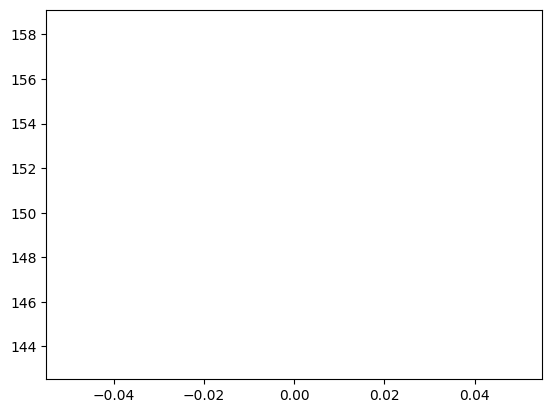

In [17]:
plt.plot(losses_list)

In [18]:
mask.shape

torch.Size([112896])

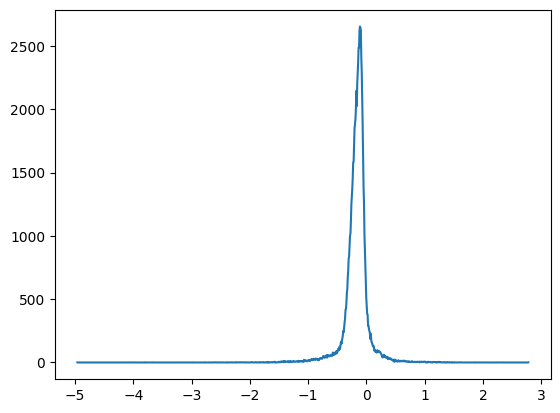

In [19]:
hist = torch.histogram(rendervar['scales'][:,0].cpu().detach(),bins = 1000)
plt.plot(hist.bin_edges[:-1],hist.hist)

In [35]:
from GRN.datasets.SurgicaL_CD import SyntheticSurgicalDepthDataset
import os
from tqdm import tqdm

seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
def readlines(filename):
    """Read all the lines in a text file and return as a list
    """
    with open(filename, 'r') as f:
        lines = f.read().splitlines()
    return lines


filenames =readlines(os.path.join('GRN/datasets/splits', "test_files.txt"))

dataset = SyntheticSurgicalDepthDataset("/media/thesis_ssd/data/Synth_depth/",filenames,336,336,[0],4,is_train=False,normalization = False)
dataloader = torch.utils.data.DataLoader(dataset,batch_size = 1,shuffle=True)

  0%|          | 0/27 [00:00<?, ?it/s]

100%|██████████| 27/27 [00:01<00:00, 17.63it/s]


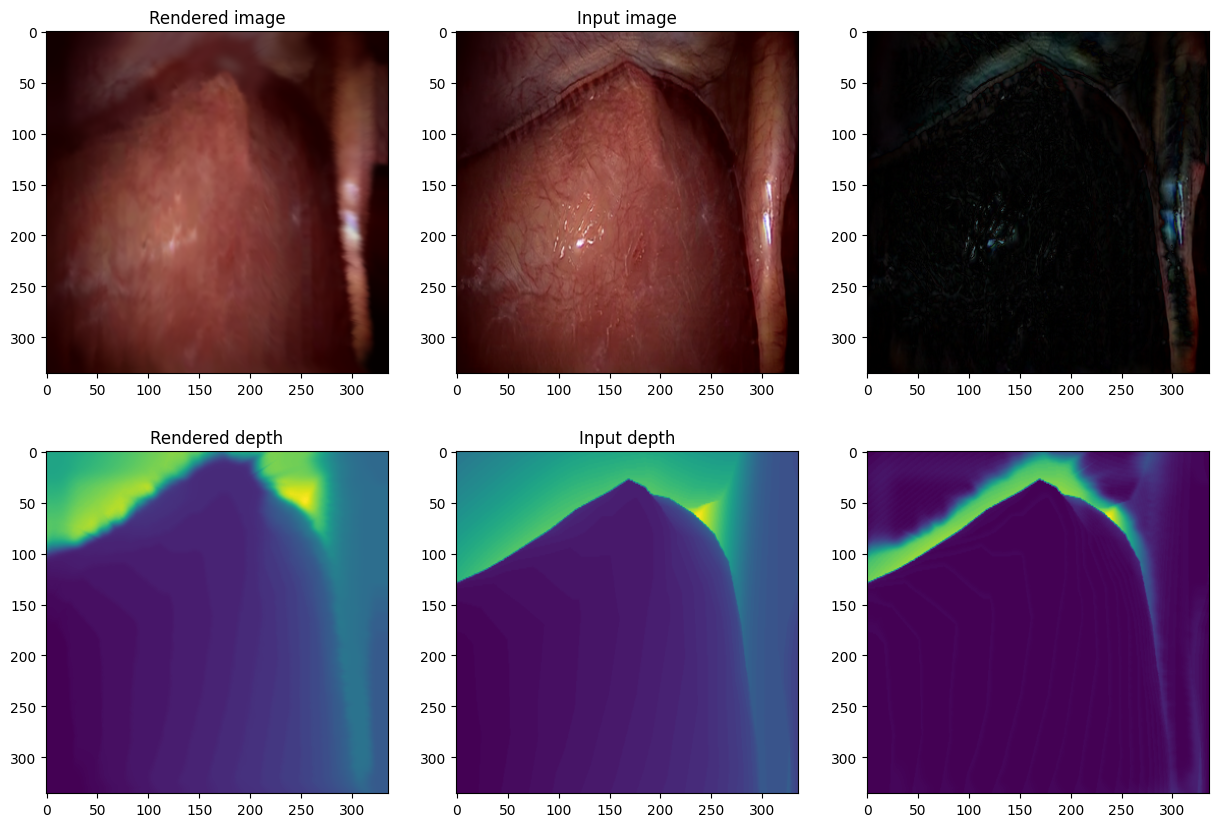

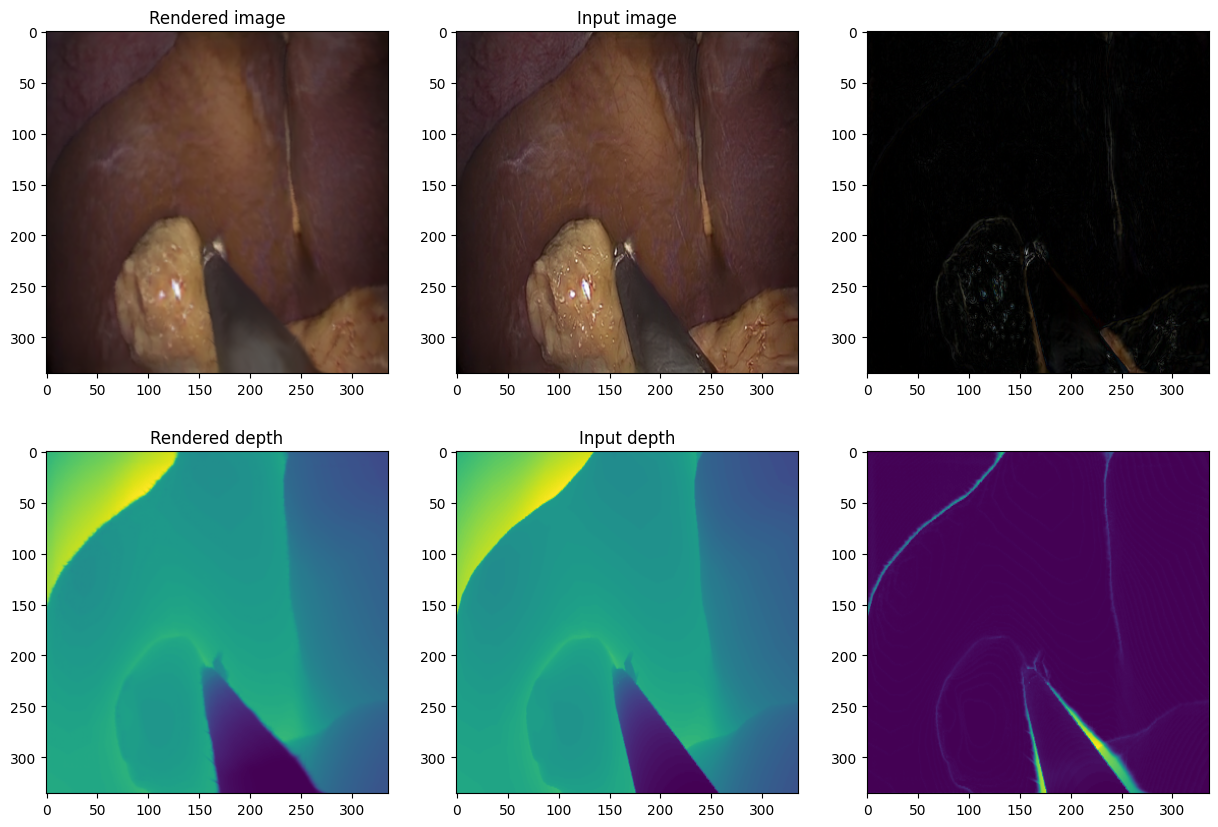

In [ ]:
loss_weights=dict(
    im=0.5,
    depth=1.0,
)
model = GaussianRegressionNetwork()


optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001)
model.cuda()
losses_list = []
for iter in range(10):
    for data in tqdm(dataloader,total = len(dataloader)):
        depth = data['depth_gt'].cuda()
        color = data[('color',0,0)].cuda()
        if depth.shape[0] == 1:
            batched_train = False
            depth = depth.squeeze(0)
            color = color.squeeze(0)
            input = torch.cat([color,depth],axis = 0).unsqueeze(0).cuda()
        else:
            batched_train = True           
            
            raise NotImplementedError('Batched training not yet implemented')
        mask = depth>1
        mask = mask.tile(1,3,1,1)
        mask = mask[0,0,:,:].reshape(-1)
        pt_cloud,mean3_sq_dist= get_pointcloud(color,depth,intrinsics,w2c,compute_mean_sq_dist=True,mask = mask)
        params,variables = initialize_params(pt_cloud,1,mean3_sq_dist)


        output = model(input)
        # print(output)
        cols = torch.permute(output[0], (1, 2, 0)).reshape(-1, 8) # (C, H, W) -> (H, W, C) -> (H * W, C)
        rots = cols[:,:4]

        scales_norm = cols[:,4:7]
        opacities = cols[:,7][:,None]

        params['unnorm_rotations'] = rots[mask]
        params['log_scales'] = scales_norm[mask]
        params['logit_opacities'] = opacities[mask]
        curr_data = {'cam': cam, 'im': color, 'depth': depth, 'id': 0, 'intrinsics': intrinsics, 
                        'w2c': w2c, 'iter_gt_w2c_list': w2c}

        # rendervar = transformed_GRNparams2rendervar(params,params['means3D'])
        # depth_sil_rendervar = transformed_GRNparams2depthplussilhouette(params, curr_data['w2c'],
        #                                                 params['means3D'])
        # im, radius, _ = Renderer(raster_settings=curr_data['cam'])(**rendervar)
        # depth_pred,_,_ = Renderer(raster_settings=curr_data['cam'])(**depth_sil_rendervar)




        # mask_loss = depth>1
        # mask_loss = mask_loss
        # img_loss = 0.8*l1_loss_v1(im,color)+ 0.2*(1-calc_ssim(im,color))
        # depth_loss = torch.abs(curr_data['depth'] - depth_pred[0,:,:])[mask_loss].sum()/mask_loss.sum()
        # loss = img_loss+5*depth_loss
        # print(loss)
        loss, variables, losses = get_loss(params, curr_data, variables, 0, loss_weights,
                            use_sil_for_loss=True, sil_thres=0,
                            use_l1=True,ignore_outlier_depth_loss=True, tracking=False,mapping=True ,
                            plot_dir=None, visualize_tracking_loss=False,
                            tracking_iteration=0,GRN_input=True,plotting = False)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses_list.append(loss.item())


    if iter%9 == 0:
        rendervar = transformed_GRNparams2rendervar(params,params['means3D'])
        depth_sil_rendervar = transformed_GRNparams2depthplussilhouette(params, curr_data['w2c'],
                                                        params['means3D'])
        im, radius, _ = Renderer(raster_settings=curr_data['cam'])(**rendervar)
        depth_pred,_,_ = Renderer(raster_settings=curr_data['cam'])(**depth_sil_rendervar)
        diff = im.permute(1,2,0).cpu().detach()-color.permute(1,2,0).cpu().detach()
        fig,ax = plt.subplots(2,3,figsize = (15,10))
        ax[0,0].imshow(im.permute(1,2,0).cpu().detach())
        ax[0,0].set_title('Rendered image')
        ax[0,1].imshow(color.permute(1,2,0).cpu().detach())
        ax[0,1].set_title('Input image')
        ax[0,2].imshow(torch.abs(diff))
        # plt.show()
        diff = depth_pred[0,:,:].cpu().detach()-depth.squeeze().cpu().detach()   
        ax[1,0].imshow(depth_pred[0,:,:].cpu().detach())
        ax[1,0].set_title('Rendered depth')
        ax[1,1].imshow(depth.permute(1,2,0).cpu().detach())
        ax[1,1].set_title('Input depth')
        ax[1,2].imshow(torch.abs(diff))

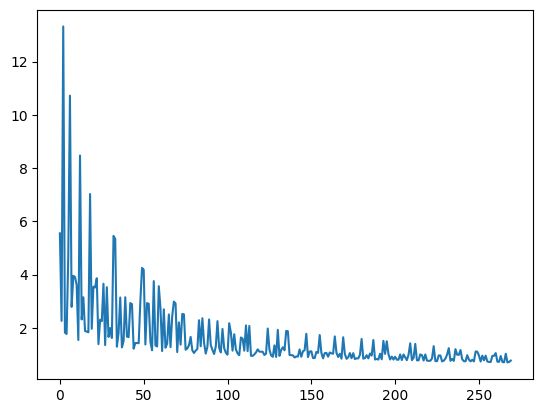

In [37]:
plt.plot(losses_list)

tensor(17.8081, device='cuda:0', grad_fn=<AddBackward0>)
tensor(17.4920, device='cuda:0', grad_fn=<AddBackward0>)
tensor(17.2360, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.9997, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.7613, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.5085, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.2445, device='cuda:0', grad_fn=<AddBackward0>)
tensor(15.9728, device='cuda:0', grad_fn=<AddBackward0>)
tensor(15.7036, device='cuda:0', grad_fn=<AddBackward0>)
tensor(15.4334, device='cuda:0', grad_fn=<AddBackward0>)


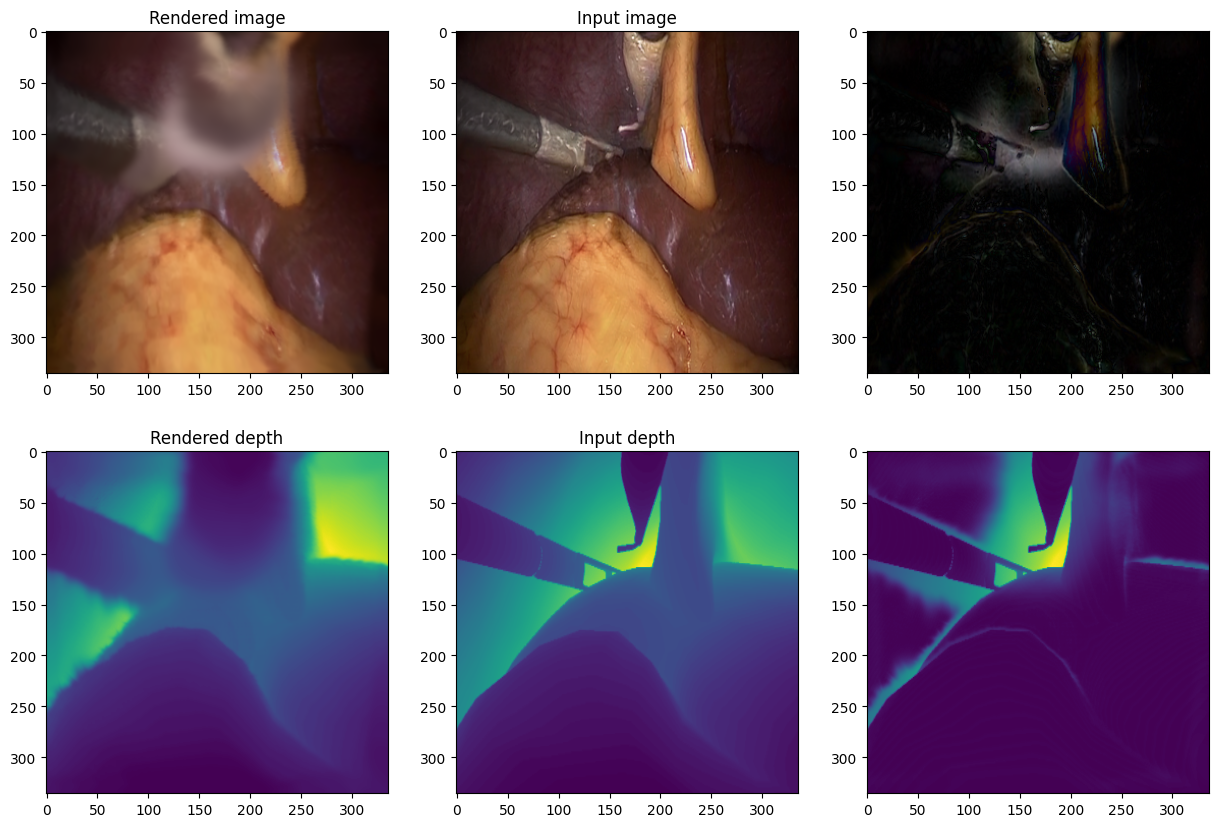

In [32]:
from GRN.datasets.SurgicaL_CD import SyntheticSurgicalDepthDataset
import os

seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
def readlines(filename):
    """Read all the lines in a text file and return as a list
    """
    with open(filename, 'r') as f:
        lines = f.read().splitlines()
    return lines


filenames =readlines(os.path.join('GRN/datasets/splits', "train_files.txt"))

dataset = SyntheticSurgicalDepthDataset("/media/thesis_ssd/data/Synth_depth/",filenames,336,336,[0],4,is_train=False,normalization = False)
dataloader = torch.utils.data.DataLoader(dataset,batch_size = 1,shuffle=False)
loss_weights=dict(
    im=0.5,
    depth=1.0,
)
model = GaussianRegressionNetwork()


optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001)
model.cuda()
losses_list = []
for iter in range(10):
    for data in dataloader:
        depth = data['depth_gt'].squeeze(0).cuda()
        color = data[('color',0,0)].squeeze().cuda()
        input = torch.cat([color,depth],axis = 0).unsqueeze(0).cuda()
        mask = depth>1
        mask = mask.tile(1,3,1,1)
        mask = mask[0,0,:,:].reshape(-1)
        pt_cloud,mean3_sq_dist= get_pointcloud(color,depth,intrinsics,w2c,compute_mean_sq_dist=True,mask = mask)
        params,variables = initialize_params(pt_cloud,1,mean3_sq_dist)


        output = model(input)
        # print(output)
        cols = torch.permute(output[0], (1, 2, 0)).reshape(-1, 8) # (C, H, W) -> (H, W, C) -> (H * W, C)
        rots = cols[:,:4]

        scales_norm = cols[:,4:7]
        opacities = cols[:,7][:,None]

        params['unnorm_rotations'] = rots[mask]
        params['log_scales'] = scales_norm[mask]
        params['logit_opacities'] = opacities[mask]


        rendervar = transformed_GRNparams2rendervar(params,params['means3D'])
        depth_sil_rendervar = transformed_GRNparams2depthplussilhouette(params, curr_data['w2c'],
                                                        params['means3D'])
        im, radius, _ = Renderer(raster_settings=curr_data['cam'])(**rendervar)
        depth_pred,_,_ = Renderer(raster_settings=curr_data['cam'])(**depth_sil_rendervar)




        mask_loss = depth>1
        mask_loss = mask_loss
        img_loss = 0.8*l1_loss_v1(im,color)+ 0.2*(1-calc_ssim(im,color))
        depth_loss = torch.abs(curr_data['depth'] - depth_pred[0,:,:])[mask_loss].sum()/mask_loss.sum()
        loss = img_loss+depth_loss
        print(loss)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses_list.append(loss.item())


        if iter%100 == 0:
            diff = im.permute(1,2,0).cpu().detach()-color.permute(1,2,0).cpu().detach()
            fig,ax = plt.subplots(2,3,figsize = (15,10))
            ax[0,0].imshow(im.permute(1,2,0).cpu().detach())
            ax[0,0].set_title('Rendered image')
            ax[0,1].imshow(color.permute(1,2,0).cpu().detach())
            ax[0,1].set_title('Input image')
            ax[0,2].imshow(torch.abs(diff))
            # plt.show()
            diff = depth_pred[0,:,:].cpu().detach()-depth.squeeze().cpu().detach()   
            ax[1,0].imshow(depth_pred[0,:,:].cpu().detach())
            ax[1,0].set_title('Rendered depth')
            ax[1,1].imshow(depth.permute(1,2,0).cpu().detach())
            ax[1,1].set_title('Input depth')
            ax[1,2].imshow(torch.abs(diff))
        break
    

In [2]:
from models.SurgeDepth.dpt import SurgeDepth
import torch
model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}
model = SurgeDepth(**model_configs['vitb']).cuda()
model.load_state_dict(torch.load('/media/thesis_ssd/code/EndoGSLAM/EndoGSLAM/models/SurgeDepth/SurgeDepthStudent_V5.pth'))
for param in model.parameters():
    param.requires_grad = False

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


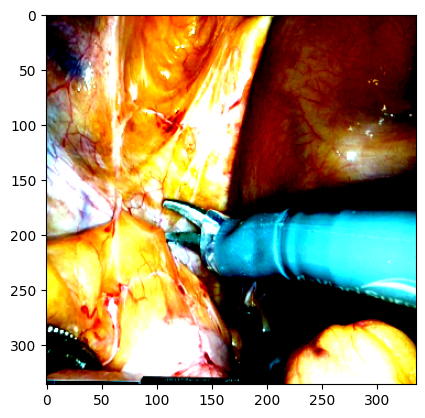

In [21]:
import cv2
import matplotlib.pyplot as plt
import torchvision
color = cv2.imread('/media/thesis_ssd/code/EndoGSLAM/EndoGSLAM/data/endonerf_cutting/images/frame-000000.color.png')
depth = cv2.imread('/media/thesis_ssd/code/EndoGSLAM/EndoGSLAM/data/endonerf_cutting/depth/frame-000000.png')
color = cv2.resize(color, (336,336))
depth = cv2.resize(depth, (336,336))
color = cv2.cvtColor(color,cv2.COLOR_BGR2RGB)
color = torch.Tensor(color).permute(2,0,1).cuda()/255
color = torchvision.transforms.functional.normalize(color,[0.46888983, 0.29536288, 0.28712815],[0.24689102 ,0.21034359, 0.21188641])
# color = (color-color.min())/(color.max()-color.min())
plt.imshow(color.permute(1,2,0).cpu().detach())


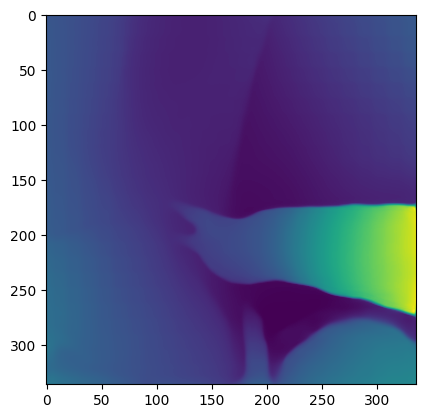

In [22]:
pred_disp  = model(color.unsqueeze(0))
plt.imshow(pred_disp.squeeze().cpu().detach())